# 01 — Current Impervious Surface Baseline (2018–2020)

This notebook builds a **baseline layer of impervious surfaces** for the city of Gothenburg
using the most recent openly available geospatial data (Urban Atlas 2018 + OpenStreetMap).

This layer will serve as the foundation for later steps in the project:
- evaluating where green–blue transformations are physically possible,
- computing suitability scores for candidate surfaces,
- running clustering or machine-learning experiments,
- and creating interactive maps for exploration.

Although no official 2023–2024 land-cover dataset is publicly available,
the combination of **Urban Atlas 2018** and **Copernicus 2020 land cover** provides
a methodologically sound approximation. The workflow is designed so that
newer datasets can be plugged in without changing the overall structure.

In this notebook, we will:
1. Load the Gothenburg municipal boundary.
2. Load Urban Atlas 2018 land-cover data and extract all artificial / impervious categories.
3. Extract impervious features from OpenStreetMap (roads, parking areas, sealed surfaces).
4. Harmonize, merge and clean the layers into a unified impervious-surface GeoDataFrame.
5. Export this baseline as GeoJSON for further analysis.
6. Visualize the results with an interactive Folium map.

We proceed step-by-step so each transformation is transparent and easily adjustable.


### 1. Gothenburg Municipal Boundary

In [2]:
import pathlib

import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import folium
import contextily as ctx

import osmnx as ox

plt.rcParams["figure.figsize"] = (10, 8)

# Base directory
PROJECT_DIR = pathlib.Path("..").resolve()

DATA_RAW = PROJECT_DIR / "data" / "raw"
DATA_PROCESSED = PROJECT_DIR / "data" / "processed"
OUTPUTS = PROJECT_DIR / "outputs"
MAPS_DIR = OUTPUTS / "maps"

PROJECT_DIR, DATA_RAW, DATA_PROCESSED, MAPS_DIR

(WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/data/raw'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/data/processed'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/outputs/maps'))

#### 1.1 Göteborgs Stad - GIS Data

The geodata used to create the boundary of the municipality, was downloaded from the official webpage of the city of Gothenburg, from their freely available repository of statistical data, which can be freely accessed through the following link: https://goteborg.se/wps/portal/enhetssida/statistik-och-analys/geografi/omradesindelningar/gisskikt-for-stadens-omradesindelning?uri=gbglnk%3A20210204104459122&utm_source=chatgpt.com

In [12]:

# Path to the stadsområden shapefile
stads_path = DATA_RAW / "Stadsområde_shp" / "Jur_stadsomraden_xu_region.shp" 

stadsomraden = gpd.read_file(stads_path)

stadsomraden.head(), stadsomraden.crs, stadsomraden.shape


(   SW_MEMBER      NAMN  AREA_KM2  STADSOMRAD           REG_DATUM  \
 0       13.0   Nordost     118.0         1.0  20250108180411.000   
 1       14.0   Sydväst      95.0         3.0  20250108180413.000   
 2       15.0   Centrum      44.0         2.0  20250108180413.000   
 3       16.0  Hisingen     402.0         4.0  20250108180413.000   
 
            AJOUR_DATU OPERATÖR  \
 0  20250108180411.000  SBKANAL   
 1  20250108180413.000  SBKANAL   
 2  20250108180413.000  SBKANAL   
 3  20250108180413.000  SBKANAL   
 
                                             geometry  
 0  MULTIPOLYGON Z (((154918.111 6404155.384 0, 15...  
 1  MULTIPOLYGON Z (((149957.096 6384913.47 0, 149...  
 2  POLYGON Z ((148569.005 6395338.737 0, 148551.9...  
 3  MULTIPOLYGON Z (((150799.952 6410530.279 0, 15...  ,
 <Projected CRS: EPSG:3007>
 Name: SWEREF99 12 00
 Axis Info [cartesian]:
 - N[north]: Northing (metre)
 - E[east]: Easting (metre)
 Area of Use:
 - name: Sweden - communes west of approximately 

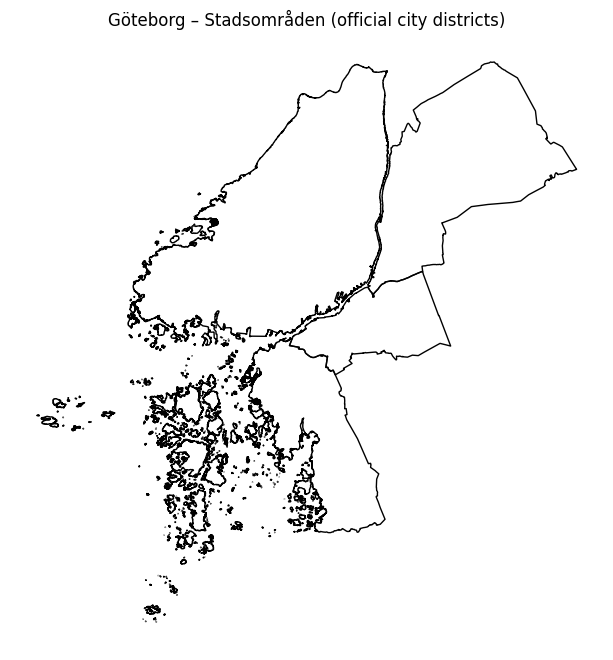

In [13]:
ax = stadsomraden.plot(
    figsize=(8, 8),
    edgecolor="black",
    facecolor="none"
)
ax.set_title("Göteborg – Stadsområden (official city districts)")
ax.set_axis_off()
plt.show()


In [14]:
# Dissolve all stadsområden polygons into a single multipolygon
gothenburg_boundary = stadsomraden.dissolve() 

gothenburg_boundary


,geometry,SW_MEMBER,NAMN,AREA_KM2,STADSOMRAD,REG_DATUM,AJOUR_DATU,OPERATÖR
0,"MULTIPOLYGON Z (((133104.574 6376193.484 0, 13...",13.0,Nordost,118.0,1.0,20250108180411.000,20250108180411.000,SBKANAL


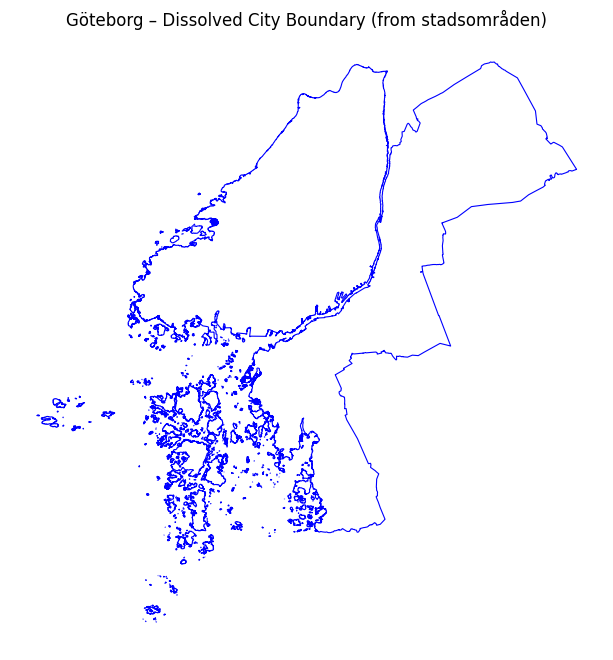

In [18]:
ax = gothenburg_boundary.plot(
    figsize=(8, 8),
    edgecolor="blue",
    facecolor="none",
    linewidth=0.8
)
ax.set_title("Göteborg – Dissolved City Boundary (from stadsområden)")
ax.set_axis_off()
plt.show()


#### 1.2 Urban Atlas Land Cover/Land Use 2018

In [19]:
# Path to the Urban Atlas 2018 base land-cover layer for Gothenburg FUA
ua2018_path = DATA_RAW / "SE002L1_GOTEBORG_UA2018_v013.gpkg" 

ua2018 = gpd.read_file(ua2018_path)

ua2018.head(), ua2018.crs, ua2018.shape


d:\Programming\geo-projects\impervious-to-green-gbg\.venv\lib\site-packages\pyogrio\geopandas.py:382: UserWarning: More than one layer found in 'SE002L1_GOTEBORG_UA2018_v013.gpkg': 'SE002L1_GOTEBORG_UA2018' (default), 'SE002L1_GOTEBORG_UA2018_Boundary', 'SE002L1_GOTEBORG_UA2018_UrbanCore'. Specify layer parameter to avoid this warning.
  result = read_func(


(  country  fua_name fua_code code_2018  \
 0      SE  Göteborg  SE002L1     11230   
 1      SE  Göteborg  SE002L1     12100   
 2      SE  Göteborg  SE002L1     11220   
 3      SE  Göteborg  SE002L1     12100   
 4      SE  Göteborg  SE002L1     11230   
 
                                           class_2018 prod_date     identifier  \
 0  Discontinuous low density urban fabric (S.L. :...   2020-07   3575-SE002L1   
 1  Industrial, commercial, public, military and p...   2020-07  30896-SE002L1   
 2  Discontinuous medium density urban fabric (S.L...   2020-07   2075-SE002L1   
 3  Industrial, commercial, public, military and p...   2020-07  30487-SE002L1   
 4  Discontinuous low density urban fabric (S.L. :...   2020-07   5928-SE002L1   
 
      perimeter           area comment  Pop2018  \
 0  2453.883435   85829.420905    None      239   
 1  3071.094329  264009.833060    None       95   
 2  3353.296323  125646.497812    None     2162   
 3  3197.451425  158528.843133    None    

In [20]:
ua2018.columns

Index(['country', 'fua_name', 'fua_code', 'code_2018', 'class_2018',
       'prod_date', 'identifier', 'perimeter', 'area', 'comment', 'Pop2018',
       'geometry'],
      dtype='object')

In [22]:
# Check CRS of both datasets
print("Boundary CRS:", gothenburg_boundary.crs)
print("UA2018 CRS:", ua2018.crs)

# Reproject UA2018 to the boundary CRS
ua2018_proj = ua2018.to_crs(gothenburg_boundary.crs)

ua2018_proj.crs


Boundary CRS: EPSG:3007
UA2018 CRS: EPSG:3035


<Projected CRS: EPSG:3007>
Name: SWEREF99 12 00
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Sweden - communes west of approximately 12°45'E and south of approximately 60°N. See information source for map.
- bounds: (10.93, 56.74, 13.11, 60.13)
Coordinate Operation:
- name: SWEREF99 12 00
- method: Transverse Mercator
Datum: SWEREF99
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
ua2018_clipped = gpd.clip(ua2018_proj, gothenburg_boundary)

ua2018_clipped.shape

(9614, 12)

In [24]:
ua2018_clipped[["code_2018", "class_2018"]].drop_duplicates().sort_values("code_2018")

,code_2018,class_2018
1403,11100,Continuous urban fabric (S.L. : > 80%)
23120,11210,Discontinuous dense urban fabric (S.L. : 50% -...
1385,11220,Discontinuous medium density urban fabric (S.L...
1402,11230,Discontinuous low density urban fabric (S.L. :...
23068,11240,Discontinuous very low density urban fabric (S...
20976,11300,Isolated structures
23102,12100,"Industrial, commercial, public, military and p..."
19060,12210,Fast transit roads and associated land
215,12220,Other roads and associated land
33335,12230,Railways and associated land


In [25]:
# impervious / artificial

UA2018_ARTIFICIAL_CODES = {
    "11100",  # Continuous urban fabric
    "11210", "11220", "11230", "11240",  # Discontinuous urban fabric
    "11300",  # Isolated structures
    "12100",  # Industrial, commercial, public, military, private units
    "12210", "12220", "12230",  # Roads and railways
    "12300",  # Port areas
    "12400",  # Airports
    "13100",  # Mineral extraction and dump sites
    "13300",  # Construction sites
    "13400",  # Land without current use
}

ua2018_clipped["code_2018_str"] = ua2018_clipped["code_2018"].astype(str)

ua2018_artificial = ua2018_clipped[
    ua2018_clipped["code_2018_str"].isin(UA2018_ARTIFICIAL_CODES)
].copy()

ua2018_artificial.shape


(6127, 13)

In [26]:
# Compute area (in m² and hectares) for UA2018 artificial polygons 

ua2018_artificial["area_m2"] = ua2018_artificial.geometry.area
ua2018_artificial["area_ha"] = ua2018_artificial["area_m2"] / 10_000

total_area_ha = ua2018_artificial["area_ha"].sum()

print(f"Number of impervious polygons (UA2018): {len(ua2018_artificial)}")
print(f"Total impervious area (UA2018, within Göteborg boundary): {total_area_ha:.2f} ha")

ua2018_artificial["code_2018_str"].value_counts()


Number of impervious polygons (UA2018): 6127
Total impervious area (UA2018, within Göteborg boundary): 14959.13 ha


code_2018_str
11230    1562
12100    1339
11220     803
11240     779
11300     569
11210     510
11100     325
13400      74
12300      51
12220      38
13100      29
12230      21
13300      14
12210      12
12400       1
Name: count, dtype: int64

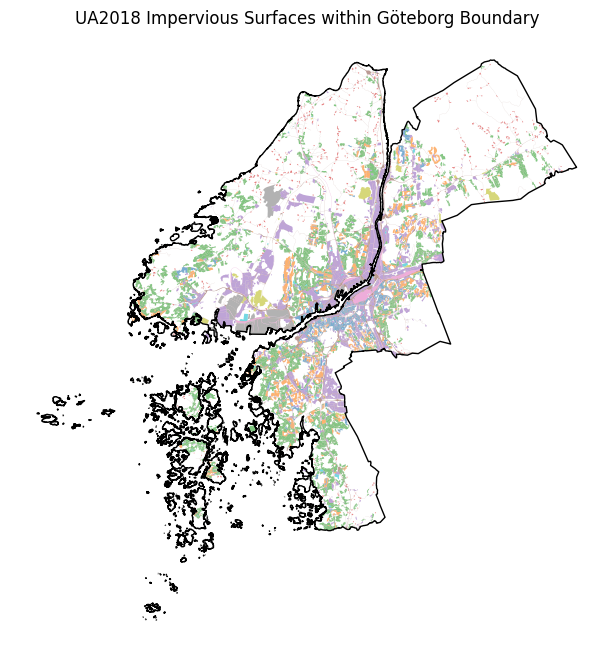

In [27]:
ax = ua2018_artificial.plot(
    figsize=(8, 8),
    column="code_2018_str",
    categorical=True,
    legend=False,
    alpha=0.6,
    edgecolor="none"
)
gothenburg_boundary.boundary.plot(ax=ax, color="black", linewidth=1)
ax.set_title("UA2018 Impervious Surfaces within Göteborg Boundary")
ax.set_axis_off()
plt.show()


### 2. OSM Impervious Features

In [29]:
# Convert Gothenburg boundary to lat/lon
boundary_wgs = gothenburg_boundary.to_crs(epsg=4326)

# Extract roads in bounding polygon
osm_roads = ox.features_from_polygon(
    boundary_wgs.iloc[0].geometry,
    tags={'highway': True}   # all highways, including small residential streets
)

osm_roads = osm_roads.to_crs(gothenburg_boundary.crs)

osm_roads.head(), osm_roads.shape

In [30]:
# Keep only lines (ignore polygons)
osm_road_lines = osm_roads[osm_roads.geometry.type == "LineString"].copy()

# Buffer roads to 5 meters (≈ 10m wide roads, simplified)
osm_road_polygons = osm_road_lines.copy()
osm_road_polygons["geometry"] = osm_road_lines.buffer(5)

# Clip to city boundary
osm_road_polygons = gpd.clip(osm_road_polygons, gothenburg_boundary)

osm_road_polygons.shape


(100794, 425)

In [32]:
osm_parking = ox.features_from_polygon(
    boundary_wgs.iloc[0].geometry,
    tags={'amenity': 'parking'}
)

osm_parking = osm_parking.to_crs(gothenburg_boundary.crs)

# Keep only polygons
osm_parking = osm_parking[osm_parking.geometry.type.isin(["Polygon", "MultiPolygon"])]

# Clip
osm_parking = gpd.clip(osm_parking, gothenburg_boundary)

osm_parking.shape


(6722, 102)

In [33]:
# Remove very small polygons from OSM-derived layers 

MIN_AREA_M2 = 50 

# Roads
osm_road_polygons["area_m2"] = osm_road_polygons.geometry.area
osm_road_polygons = osm_road_polygons[osm_road_polygons["area_m2"] >= MIN_AREA_M2].copy()

# Parking
osm_parking["area_m2"] = osm_parking.geometry.area
osm_parking = osm_parking[osm_parking["area_m2"] >= MIN_AREA_M2].copy()

len(osm_road_polygons), len(osm_parking)

(100781, 5995)

In [34]:
# Make sure UA has area column for consistency
if "area_m2" not in ua2018_artificial.columns:
    ua2018_artificial["area_m2"] = ua2018_artificial.geometry.area
ua2018_artificial["area_ha"] = ua2018_artificial["area_m2"] / 10_000

# Tag sources
ua2018_artificial["source"] = "ua2018"
osm_road_polygons["source"] = "osm_road"
osm_parking["source"] = "osm_parking"

# Harmonise columns before concatenation
common_cols = ["source", "area_m2", "geometry"]

impervious_current = pd.concat(
    [
        ua2018_artificial[common_cols],
        osm_road_polygons[common_cols],
        osm_parking[common_cols],
    ],
    ignore_index=True,
)

impervious_current["area_ha"] = impervious_current["area_m2"] / 10_000

impervious_current = gpd.GeoDataFrame(
    impervious_current,
    geometry="geometry",
    crs=gothenburg_boundary.crs,
)

impervious_current.shape


(112903, 4)

In [35]:
# Basic stats

print("Total impervious polygons (UA + OSM):", len(impervious_current))
print(
    "Total impervious area (UA + OSM, ha):",
    impervious_current["area_ha"].sum().round(2),
)

print("\nBy source:")
print(
    impervious_current
    .groupby("source")["area_ha"]
    .sum()
    .round(2)
)

Total impervious polygons (UA + OSM): 112903
Total impervious area (UA + OSM, ha): 24028.16

By source:
source
osm_parking      442.32
osm_road        8626.71
ua2018         14959.13
Name: area_ha, dtype: float64


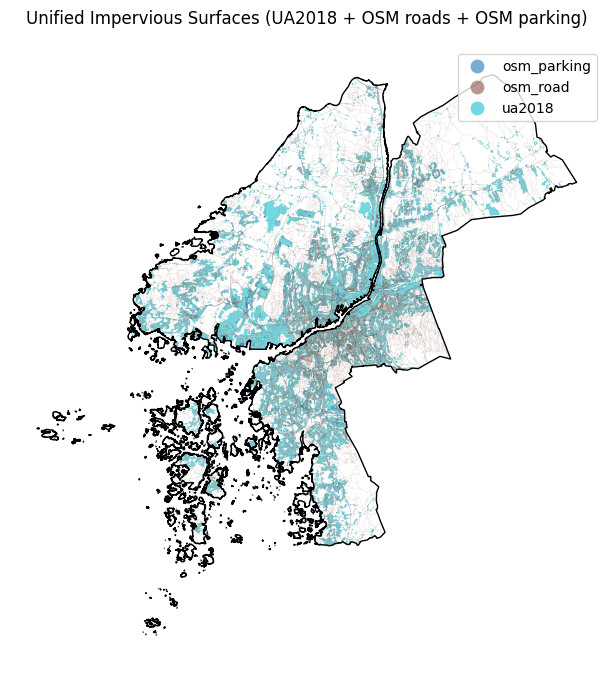

In [36]:
ax = impervious_current.plot(
    figsize=(8, 8),
    column="source",
    categorical=True,
    legend=True,
    alpha=0.6,
    edgecolor="none",
)
gothenburg_boundary.boundary.plot(ax=ax, color="black", linewidth=1)
ax.set_title("Unified Impervious Surfaces (UA2018 + OSM roads + OSM parking)")
ax.set_axis_off()
plt.show()


## 3. Export Impervious Layer

In [37]:
# Prepare output directories
output_dir = DATA_PROCESSED
output_dir.mkdir(parents=True, exist_ok=True)

# Export to GeoJSON
geojson_path = output_dir / "impervious_current.geojson"
impervious_current.to_file(geojson_path, driver="GeoJSON")
print("Saved:", geojson_path)

# Export to GeoPackage (recommended for QGIS)
gpkg_path = output_dir / "impervious_current.gpkg"
impervious_current.to_file(gpkg_path, driver="GPKG")
print("Saved:", gpkg_path)


Saved: D:\Programming\geo-projects\impervious-to-green-gbg\data\processed\impervious_current.geojson
Saved: D:\Programming\geo-projects\impervious-to-green-gbg\data\processed\impervious_current.gpkg


## 4. Interactive Map

In [38]:
from folium import GeoJson

# Center map on Göteborg 
center = [57.7089, 11.9746]

m = folium.Map(location=center, zoom_start=10, tiles="CartoDB positron")


# Function to add a GeoDataFrame to folium with a layer name
def add_layer(gdf, layer_name, color):
    gdf_wgs = gdf.to_crs(epsg=4326)
    geojson = folium.GeoJson(
        gdf_wgs,
        name=layer_name,
        style_function=lambda feature: {
            "color": color,
            "weight": 0,
            "fillOpacity": 0.5,
        },
    )
    geojson.add_to(m)

# Add layers
add_layer(ua2018_artificial, "UA2018 Impervious", "#3182bd")   # blue
add_layer(osm_road_polygons, "OSM Roads (buffered)", "#de2d26")  # red
add_layer(osm_parking, "OSM Parking", "#31a354")                 # green

folium.LayerControl().add_to(m)

# Save
interactive_path = MAPS_DIR / "impervious_current_map.html"
interactive_path.parent.mkdir(parents=True, exist_ok=True)
m.save(str(interactive_path))

interactive_path


WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/outputs/maps/impervious_current_map.html')

In [40]:
# Much lighter version without roads 
center = [57.7089, 11.9746]

m_light = folium.Map(location=center, zoom_start=10, tiles="CartoDB positron")

# Only geometry column
ua_light = ua2018_artificial[["geometry"]].to_crs(epsg=4326).copy()
parking_light = osm_parking[["geometry"]].to_crs(epsg=4326).copy()

# UA layer
GeoJson(
    ua_light,
    name="UA2018 Impervious",
    style_function=lambda f: {
        "color": "#3182bd",
        "weight": 0,
        "fillOpacity": 0.5,
    },
).add_to(m_light)

# Parking layer
GeoJson(
    parking_light,
    name="OSM Parking",
    style_function=lambda f: {
        "color": "#31a354",
        "weight": 0,
        "fillOpacity": 0.7,
    },
).add_to(m_light)

folium.LayerControl().add_to(m_light)

# Save lightweight map
light_map_path = MAPS_DIR / "impervious_current_light.html"
light_map_path.parent.mkdir(parents=True, exist_ok=True)
m_light.save(str(light_map_path))

print("Saved:", light_map_path)


Saved: D:\Programming\geo-projects\impervious-to-green-gbg\outputs\maps\impervious_current_light.html


In [41]:
from IPython.display import IFrame

light_map_path = MAPS_DIR / "impervious_current_light.html"
IFrame(src=str(light_map_path), width=900, height=600)


# Summary — Current Impervious Baseline for Göteborg

In this notebook we constructed a unified, high-resolution map of current impervious surfaces in the City of Göteborg, combining authoritative land-cover data from Urban Atlas 2018 with additional detail from OpenStreetMap.

---

## 1. Municipal Boundary

We used Göteborgs Stad’s official **stadsområden** GIS layers (CC0 license).  
All polygons were dissolved into a single municipal boundary and used as the spatial clip mask for the analysis.

---

## 2. Urban Atlas 2018 (UA2018)

Urban Atlas provides consistent, Europe-wide land-cover data.  
We clipped the layer to the municipal boundary, reprojecting from **EPSG:3035 → EPSG:3007**.

Impervious land-cover classes (e.g., **11100–13400**) were extracted based on Copernicus definitions.

**Results:**

- 6,127 impervious polygons  
- ~14,959 ha of sealed surface  
- Major contributors: discontinuous urban fabric, industrial areas, mixed commercial areas  

---

## 3. OpenStreetMap Additions

To complement UA data, we extracted OSM features inside the boundary:

- Roads (buffered linework into polygons)
- Parking areas (polygon features)

After removing tiny slivers (<50 m²), these layers contributed meaningful detail, especially for minor roads and distributed parking infrastructure.

**Additional impervious area:**

- OSM roads: ~8,627 ha  
- OSM parking: ~442 ha  

---

## 4. Unified Impervious Layer

We harmonised all datasets and combined them into a single GeoDataFrame.

**Final combined totals:**

- Total impervious area (UA + OSM): **~24,028 ha**  
- Total polygons: **112,903**  
- Each polygon retains a `source` attribute (`ua2018`, `osm_road`, `osm_parking`)

**Exports:**

- `data/processed/impervious_current.geojson`  
- `data/processed/impervious_current.gpkg`  

---

## 5. Interactive Map

A zoomable **Folium** map was generated, allowing layer toggling and inspection:

- UA2018 impervious  
- OSM roads  
- OSM parking  

This interactive visualisation supports rapid exploration and forms the baseline for subsequent modelling.

---

## How this fits the project

This unified impervious baseline is the foundation for all subsequent notebooks:

- **Notebook 02:** Feature engineering on impervious polygons  
- **Notebook 03:** Suitability scoring (environmental, spatial, social features)  
- **Notebook 04:** ML classifier predicting surfaces likely to become sealed  
- **Notebook 05:** Priority mapping & exporting insights  

By combining authoritative satellite-derived land cover with community-mapped infrastructure, we capture the full spectrum of urban sealed surfaces, a necessary step for analysing where Göteborg could realistically convert grey infrastructure into multifunctional green space, directly supporting the RISE Grey to Green initiative.
